# **Algoritmo para extraer las palabras de una imagen procesada por la red YOLO**

Última fase del flujo de trabajo propuesto y explorado durante este proyecto. Se plantea como una prueba de concepto, ya que se aplica sobre una imagen creada para garantizar una situación ideal y así poder validar el algoritmo.

Para su ejecución se requiere del modelo de la red entrenada, el cual está disponible en el repositorio y tiene el nombre "best.pt" y la imagen creada, también disponible en el repositorio, bajo el nombre "TEXTO_PRUEBA_2_RENGLONES.png"


In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 911.6/911.6 kB 9.2 MB/s eta 0:00:00


# **Detección de caracteres y Formación de palabras**

In [2]:
def dibujar_centros_y_orden(imagen, renglones, output_path="centros_ordenados.png"):
    """
    Dibuja las cajas, los centros (en azul) y el orden de las cajas agrupadas por renglones en una imagen.

    Args:
        imagen (str): Ruta de la imagen original.
        renglones (list): Lista de renglones, donde cada renglón es una lista de cajas ordenadas.
        output_path (str): Ruta para guardar la imagen con el dibujo.

    Returns:
        None
    """
    # Cargar la imagen
    img = cv2.imread(imagen)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen en {imagen}")

    # Dibujar las cajas, los centros y el orden
    for renglon_idx, renglon in enumerate(renglones):
        for palabra_idx, (x1, y1, x2, y2, centro_x, centro_y, _, _, _) in enumerate(renglon):
            # Dibujar la caja en verde
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            # Dibujar el centro en azul
            cv2.circle(img, (int(centro_x), int(centro_y)), 5, (255, 0, 0), -1)
            # Dibujar el índice del orden debajo del centro
            texto = f"{renglon_idx + 1}.{palabra_idx + 1}"
            cv2.putText(
                img,
                texto,
                (int(centro_x), int(centro_y) + 15),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (0, 0, 0),
                2,
            )

    # Guardar la imagen resultante
    cv2.imwrite(output_path, img)
    print(f"Imagen con las cajas, centros y orden guardada en {output_path}")

def agrupar_etiquetas_por_renglones(cajas, threshold=0.5, tolerancia_vertical=0.5):
    """
    Agrupa etiquetas de las cajas en palabras, diferenciando por renglones y ordenando de izquierda a derecha.

    Args:
        cajas (list): Lista de resultados de detección, con cada elemento en formato [x1, y1, x2, y2, score, class_id].
        threshold (float): Umbral de puntuación para considerar una detección válida.
        tolerancia_vertical (float): Fracción del alto de la caja para diferenciar renglones.

    Returns:
        tuple: (renglones_palabras, renglones_cajas), donde:
            - renglones_palabras: Lista de renglones, cada renglón es una lista de palabras agrupadas.
            - renglones_cajas: Lista de renglones, cada renglón es una lista de cajas completas ordenadas.
    """
    # Filtrar cajas válidas según el umbral de la predicción
    cajas_validas = [
        (x1, y1, x2, y2, (x1 + x2) / 2, (y1 + y2) / 2, x2 - x1, y2 - y1, results.names[int(class_id)].upper())
        for x1, y1, x2, y2, score, class_id in cajas
        if score > threshold
    ]

    # Ordenar por la coordenada Y del centro (de arriba hacia abajo)
    cajas_validas.sort(key=lambda c: c[5])  # c[5] es el centro en Y

    # Agrupar por renglones
    renglones_cajas = []
    renglon_actual = []
    ultima_caja = None

    for caja in cajas_validas:
        x1, y1, x2, y2, centro_x, centro_y, ancho, alto, label = caja

        if ultima_caja is None:
            # Primera caja
            renglon_actual.append(caja)
        else:
            _, ultimo_y1, _, ultimo_y2, _, ultimo_centro_y, _, ultimo_alto, _ = ultima_caja
            # Si la diferencia en Y es menor al umbral
            if abs(centro_y - ultimo_centro_y) <= tolerancia_vertical * ultimo_alto:
                renglon_actual.append(caja)
            else:
                # Nuevo renglón detectado
                renglones_cajas.append(renglon_actual)
                renglon_actual = [caja]

        ultima_caja = caja

    # Agregar el último renglón si existe
    if renglon_actual:
        renglones_cajas.append(renglon_actual)

    # Ordenar cada renglón por la coordenada X del centro
    for renglon in renglones_cajas:
        renglon.sort(key=lambda c: c[4])  # c[4] es el centro en X

    # Agrupar por palabras en cada renglón
    renglones_palabras = []
    for renglon in renglones_cajas:
        palabras = []
        palabra_actual = ""
        ultima_caja = None

        for caja in renglon:
            x1, y1, x2, y2, centro_x, centro_y, ancho, alto, label = caja

            if ultima_caja is None:
                # Primera caja del renglón
                palabra_actual = label
            else:
                _, _, _, _, ultimo_centro_x, _, ultimo_ancho, _, _ = ultima_caja
                # Verificar si la distancia entre los centros es menor a 1.2 veces el ancho
                if abs(centro_x - ultimo_centro_x) <= 2 * ultimo_ancho:
                    palabra_actual += label
                else:
                    # Nueva palabra detectada
                    palabras.append(palabra_actual)
                    palabra_actual = label

            ultima_caja = caja

        # Agregar la última palabra si existe
        if palabra_actual:
            palabras.append(palabra_actual)

        renglones_palabras.append(palabras)

    return renglones_palabras, renglones_cajas



0: 128x128 2 as, 2 bs, 4 es, 2 os, 2 ps, 2 rs, 4 ts, 2 us, 2 xs, 101.8ms
Speed: 1.0ms preprocess, 101.8ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)


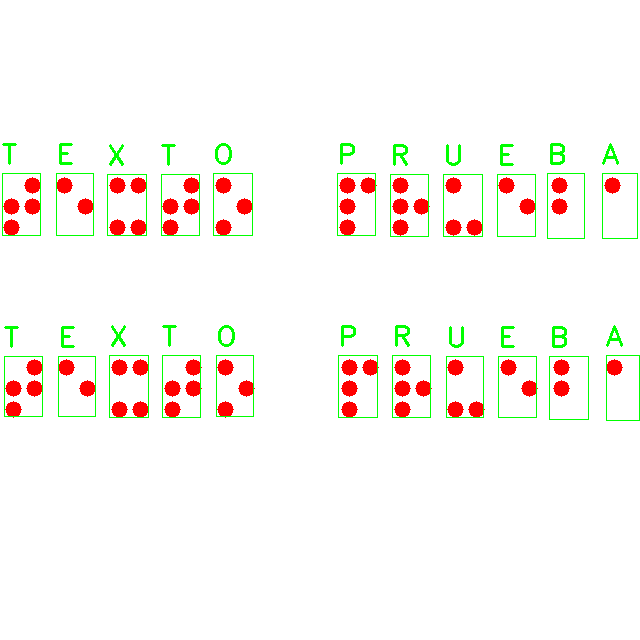

In [6]:
import cv2
from google.colab.patches import cv2_imshow
import os
from ultralytics import YOLO

# Ruta de la imagen
image_path = "/content/TEXTO_PRUEBA_2_RENGLONES.png"
# Cargar la imagen
frame = cv2.imread(image_path)

# Redimensionar
resized_frame = cv2.resize(frame, (640, 640), interpolation=cv2.INTER_AREA)

# Cargar el modelo YOLO entrenado
model_path = "/content/best.pt"
model = YOLO(model_path)

# Pasar la imagen redimensionada por la red YOLO
results = model(resized_frame)[0]

frame = resized_frame

threshold = 0.4

for result in results.boxes.data.tolist():
  x1, y1, x2, y2, score, class_id = result

  if score > threshold:
    cv2.rectangle(frame, (int(x1), int(y1)),(int(x2),int(y2)), (0,255,0), 1)
    # Verifica si class_id es 0 (y asigna el texto "PINGUINO")
    label = results.names[int(class_id)].upper()
    # Coloca el texto sobre el rectángulo
    cv2.putText(frame, label, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

cv2_imshow(frame)

In [7]:
cajas = results.boxes.data.tolist()
renglones_palabras, renglones_cajas = agrupar_etiquetas_por_renglones(cajas, threshold)

for i, palabras in enumerate(renglones_palabras):
    print(f"Renglón {i+1}: {palabras}")

Renglón 1: ['TEXTO', 'PRUEBA']
Renglón 2: ['TEXTO', 'PRUEBA']


In [8]:
dibujar_centros_y_orden(image_path, renglones_cajas, output_path="/content/output2.png")

Imagen con las cajas, centros y orden guardada en /content/output2.png


In [9]:
pred = model.predict(resized_frame)[0]
pred = pred.plot()
cv2.imwrite("/content/output3.png",pred)


0: 128x128 1 a, 1 b, 1 e, 1 i, 2 os, 1 p, 2 rs, 1 s, 4 ts, 2 us, 2 xs, 1 z, 98.6ms
Speed: 0.9ms preprocess, 98.6ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 128)


True